# INFO 6/3350

# Problem Set 2: Feature importance, group differences, and topic models

---
## NetID: apk67

## Name: Aditya Kakade

### People with whom you discussed this problem set: Gabby Fite gff29

### Did you consult AI concerning any aspect of this problem set (see the class [AI policy](https://github.com/wilkens-teaching/info3350-f24?tab=readme-ov-file#generative-artificial-intelligence))?:
---

## Instructions for submission

1. Supply your name, NetID, and other information above.
1. Submit your completed work via CMS.
1. **Remember to execute every cell of code! Unexecuted code will receive zero credit.** The best way to make sure that everything is in order is to restart your kernel and run all cells immediately prior to submission.
1. Make sure to print all outputs with informative labels.
1. You will submit *both* this fully executed notebook *and* a PDF copy of it. TAs will grade the PDF copy. TAs may refer to or run the code as necessary, but they will not execute it to fill in missing outputs.
1. To generate a PDF version of the completed notebook, export the notebook to HTML, open the resulting HTML file in your browser, and print the rendered HTML to PDF from your browser. You may produce the PDF in other ways, but you are solely responsible for verfiying that it is correct and complete.

## Summary

Explore approaches to characterizing corpora. A problem set in three parts:

1. Quantifying feature differences between genres via permutation tests and bootstrapping.
2. Identifying distinctive terms of different genres via Fightin' Words.
3. Using modeled topics as feature inputs for classification of Supreme Court opinions.

## Part 1. Feature differences across corpora.

The dataset used in this part of the problem set is the same [data released by Ted Underwood](https://github.com/tedunderwood/horizon/tree/master) used in the previous problem set, but now we've included a small number of books belonging to the `horror` genre. We have once again retained only a subset of the token unigram features for your text-mining convenience. 

In [1]:
## Imports and setup
## All imports here, none in your code below
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import fightinwords as fw
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from   sklearn.feature_selection import SelectKBest, mutual_info_classif



### 1. Read in feature data and metadata (2 points)¶
Read in as a pandas dataframe the feature data contained in the file `genre-features-myst-scifi-horror.csv.gz` in the `data/mystery_scifi` directory of the course GitHub repo.

Display the shape and first 3 rows of the resulting dataframe.

In [2]:
### Read in the feature data
myst_scifi = pd.read_csv('genre-features-myst-scifi-horror.csv.gz')
display(myst_scifi.head(n=3))

C:\Users\adika\AppData\Local\Temp\ipykernel_28596\3044690290.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  myst_scifi = pd.read_csv('genre-features-myst-scifi-horror.csv.gz')


,docid,the,and,to,a,of,i,he,in,was,...,appointments,imminent,flooding,purring,lick,lookin,hinges,lounds,brownstone,GENRE LABEL
0,uiuo.ark+=13960=t2b85z60c,3520.132114,3068.164534,3285.456639,1842.637057,2835.661980,1486.278004,1162.512766,1647.074162,1564.503162,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,horror
1,uiuo.ark+=13960=t4km00443,4263.466283,3441.097862,3202.097039,1906.866776,3148.129112,1071.648849,1051.089638,1516.241776,1536.800987,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,horror
2,uiuo.ark+=13960=t6zw24n6x,4189.273539,2876.074327,2916.886734,1874.969991,3029.721035,1209.967830,751.428434,1658.904307,1483.651030,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,horror


### 2. Compare one feature across genres (3 points)

For each of the three genres in the dataset, calculate the mean and standard deviation of the data for the word `fear`. `print` your results in an easily legible format. Example:

```
Means and standard deviations by genre ("fear")
genre       mean    std
horror      <num>   <num>
mystery     <num>   <num>
scifi       <num>   <num>
```

These calculations (including the next two problems) should be simple review from INFO 2950. If you want a refresher, see [the relevant lecture notes](https://drive.google.com/file/d/1UdzDduMeNGtU8T5xsrSpwnYDmRQ1r-HB/view?usp=sharing) (NB. requires Cornell Google login for access).

In [3]:
# mean and std
h_only = myst_scifi[myst_scifi['GENRE LABEL'] == 'horror']['fear'].describe()
m_only = myst_scifi[myst_scifi['GENRE LABEL'] == 'mystery']['fear'].describe()
s_only = myst_scifi[myst_scifi['GENRE LABEL'] == 'scifi']['fear'].describe()

results_df = pd.DataFrame({
                      'genre' : ['horror', 'mystery', 'scifi'],
                      'mean' : [h_only['mean'], m_only['mean'], s_only['mean']],
                      'scifi': [h_only['std'], m_only['std'], s_only['std']]
                      })
results_df = results_df.set_index('genre')
display(results_df)

,mean,scifi
genre,,
horror,19.633023,13.434484
mystery,11.267686,12.906909
scifi,21.775847,17.909074


### 3. Confidence intervals via bootstrap resampling (10 points)

Using bootstrap resampling, calculate the empirical 95% confidence interval around each genre's mean for the same word (`fear`). Again, `print` your results in legible format. Example:

```
95% confidence interval of the mean by genre ("fear")
genre       low     high
horror      <num>   <num>
mystery     <num>   <num>
scifi       <num>   <num>
```

Write your own code to accomplish this task rather than relying on libraries. You may, of course, use implementing libraries like `numpy` and `pandas` as you see fit.

In [4]:
# function for confidence intervals via bootstrapping

def bootstrap_ci(X, ci=0.95, iters=10000):
    '''Calculate a confidence interval via bootstrap resampling with replacement.

    Takes a pandas series and optional values for ci and iterations.
    Returns a numpy array with low and high values of the confidence interval.
    
    X is your dataframe.
    ci sets the width of your confidence interval
    iters sets the number of iterations
    '''
    bootstrap_means = np.empty(iters)

    for i in range(iters):
        resampled_x = X.sample(n=len(X), replace = True)
        bootstrap_means[i] = np.mean(resampled_x)

    conf_int = np.quantile(bootstrap_means, q = [0.025, 0.975])
    return conf_int
    

In [5]:
# code that iterates through each genre,
# activate the bootstrap function,
# and prints the results
print('95% confidence interval of the mean by genre ("fear")\ngenre       low '+
      '                 high')
for genre in ['mystery', 'horror', 'scifi']:
  rel_data = myst_scifi[myst_scifi['GENRE LABEL'] == genre]['fear']
  rel_ci = bootstrap_ci(rel_data)
  print(f'{genre}     {rel_ci[0]}    {rel_ci[1]}')

95% confidence interval of the mean by genre ("fear")
genre       low                  high
mystery     9.386629536063055    13.418745101785003
horror     14.32821155785937    25.195888507911704
scifi     19.053485049926664    24.67696314830308


### 4. Significance testing via permutation (10 points)

Using a permutation test, calculate the empirical probability of observing an equally large or larger difference in the means of this feature (`fear`) between each pair of genres in the data (e.g. between horror/mystery, horror/sci-fi, and mystery/sci-fi).

`print` your results in an easily legible format and be sure to label your p-values with the standard significance indicators (that is, `*` for p < 0.05, `**` for p < 0.01, and `***` for p < 0.001). Example (the significance indicators here do not correspond to the actual results they are just meant to showcase where they should be placed):

```
p-value of the difference in mean by genre pair using scipy version ("fear")
genre 1     genre 2    p
horror      scifi      <num> *
horror      mistery    <num> **
scifi       mistery    <num> ***
```

 Don't worry about one-sided vs. two-sided tests; either one is fine. We're more interested in the computational method than the statistical details. `scipy` implementation does standard two-tail calculations. This is fine, but not required for full credit in students' own versions.

Again, write your own code (as one or more functions) to perform the relevant calculations, do not rely on libraries. **And note that a permutation test is not the same thing as permutation importance for feature selection or model inspection.**

In [6]:
# p-values via permutation
def permutation_p(X1, X2, n_permutations = 1000):
  greater_equal_diffs = 0
  comp_diff = np.abs(np.mean(X1) - np.mean(X2))

  for i in range(n_permutations):
    permuted_Xs = pd.concat([X1, X2]).copy().values
    np.random.shuffle(permuted_Xs)
    permuted_X1 = permuted_Xs[:len(X1)]
    permuted_X2 = permuted_Xs[len(X1):]
    permuted_X1 = pd.Series(permuted_X1)
    permuted_X2 = pd.Series(permuted_X2)

    if np.abs(np.mean(permuted_X1) - np.mean(permuted_X2)) >= comp_diff:
      greater_equal_diffs += 1

  return greater_equal_diffs / n_permutations

print('p-value of the difference in mean by genre pair using scipy version ("fear")')
print('genre 1  genre 2  p')

for pair in [['horror', 'scifi'], ['horror', 'mystery'], ['scifi', 'mystery']]:
  asterisk = ''
  rel_data_1 = myst_scifi[myst_scifi['GENRE LABEL'] == pair[0]]['fear']
  rel_data_2 = myst_scifi[myst_scifi['GENRE LABEL'] == pair[1]]['fear']
  p = permutation_p(rel_data_1, rel_data_2)

  if p < 0.05:
    asterisk = '*'
  if p < 0.01:
    asterisk = '**'
  if p < 0.001:
    asterisk = '***'

  print(f'{pair[0]}  {pair[1]}  {p:.10f} {asterisk}')


p-value of the difference in mean by genre pair using scipy version ("fear")
genre 1  genre 2  p
horror  scifi  0.6130000000 
horror  mystery  0.0070000000 **
scifi  mystery  0.0000000000 ***


## Part II. Fightin' Words

Fightin' Words (sometimes fighting words or FW) is an algorithm for comparing groups of text.

If you have two groups of text based on some characteristic (such as gender or political affiliation), and you want to know more about the most representative words by group, you could use this method. 

See the `fightinwords.py` code from lecture, which has also been provided with this problem set.

### 5. Compute FW scores (20 points)

Use fightin' words to calculate the ten terms that are most characteristically overused in the `horror` genre vs. the `mystery` genre (and _vice versa_). 

`print` the top ten terms for each genre in an easily legible format. Example:

```
Top terms in mystery
<term>      <num>
<term>      <num>
...         ...

Top terms in horror
<term>      <num>
<term>      <num>
...         ...
```

Limit your features strictly to those that are present in the `scifi` genre and be sure to calculate and use an informative prior based on the observed frequencies in `scifi` books. If you choose to set a `prior_weight`, explain your choice in the answer to the next question (no. 6, below).



In [8]:
# compute and diplay fightin words results

horror = myst_scifi[myst_scifi['GENRE LABEL'] == 'horror']
horror = horror.drop(['docid', 'GENRE LABEL'], axis= 1)
mystery = myst_scifi[myst_scifi['GENRE LABEL'] == 'mystery']
mystery = mystery.drop(['docid', 'GENRE LABEL'], axis = 1)
scifi = myst_scifi[myst_scifi['GENRE LABEL'] == 'scifi']
scifi = scifi.drop(['docid', 'GENRE LABEL'], axis = 1)


rel_scifi_features = scifi.sum(axis = 0) > 0
scifi = scifi.loc[:, rel_scifi_features]
vocab = np.array(scifi.columns.tolist())
scifi = scifi.sum(axis = 0).copy().values
horror = horror.loc[:, rel_scifi_features].sum(axis = 0).copy().values
mystery = mystery.loc[:, rel_scifi_features].sum(axis = 0).copy().values

fw_input = np.array([horror, mystery])
scifi = np.array([scifi]).reshape(-1,1)

fw_scores = fw.bayes_compare_language(
    l1=[0], 
    l2=[1], 
    features=fw_input,
    prior=scifi,
    vocab = vocab
)
 
print("Top terms in mystery")
for word, fws in reversed(fw_scores[-10:]):
  print(f'{word:<8}     {fws:6.3f}')

print("\nTop terms in horror")
for word, fws in reversed(fw_scores[:10]):
  print(f'{word:<8}     {fws:6.3f}')


Vocab size is 9715
Comparing language...
Top terms in mystery
of           64.728
their        53.240
they         43.056
its          39.336
the          38.998
our          37.009
ship         36.352
upon         33.527
world        31.752
captain      31.355

Top terms in horror
she          -41.346
me           -42.999
miss         -46.759
mrs          -47.162
didn't       -48.864
mr           -49.312
said         -52.454
got          -53.463
you          -57.003
i            -112.675


### 6. Discuss the most representive words by genre (5 points)

What are some things that you find interesting about the most representative words for horror versus mystery? Do any of the terms surprise you? If you chose to set a `prior_weight`, why did you select the value you did?

I find interesting how the top terms in horror aren't words that I immediately associate with fear or scary stories.  Instead, almost all the top words are pronouns or gender titles, with the exception of 'didn't' and 'got'.  I can see why these terms might be the way they are, though -- horror texts most likely have a good a mount of action involving the characters and their interactions with the paranormal, so title references and pronouns might be more prevalent.  The top terms for mystery make more sense to me -- the inclusion of words like 'ship,' 'world,' and 'captain' suggest a trend towards stories that are more based on the environment the text is set in.  What does confuse me is how 'ship' and 'captain' made the top terms list -- are most mystery texts in this corpus ocean/sea based?

## Part III. Topic models.

Now we will move to a different corpus, a set of historical US Supreme Court opinions. You can find the data in the course GitHub repo as `data/us_supreme_court/supreme_court_opinions_and_issues.csv.gz`.

Follow these steps:
- Read this data into a pandas dataframe. (Question no. 7)
- Vectorize the `text` portion of the data using reasonable settings (Question no. 7)
- Fit an LDA topic model with 20 topics on the resulting token feature matrix (Question no. 8)
- Use the per-document topic probability distributions as input features for a logistic regression classifier to predict the `issue_area` of each opinion. (Question no. 10)
- Use the 20 most informative token features (selected by the mutual information score) as input features for a logistic regression classifier to predict the `issue_area` of each opinion (Question no. 11)
- Use the first 20 components of an SVD decomposition as input features for a logistic regression classifier to predict the `issue_area` of each opinion (Question no. 12)
- Compare the performance of the model trained on LDA probabilities to that of the other two models. 

### 7. Read data and vectorize text (5 points)

`print` the first few lines of the dataframe and the shape of your vectorized feature matrix.

In [9]:
# read the csv file and print the first few lines of the dataframe 
sc_data = pd.read_csv('supreme_court_opinions_and_issues.csv.gz')
print(sc_data.shape)
display(sc_data.head())


(13561, 5)


,case_id,text,type,year,issue_area
0,1973-067,A draftee accorded Class I-O conscientious obj...,opinion,1974,civil rights
1,1973-067,In my dissent applicable to Braunfield v. Brow...,dissent,1974,civil rights
2,1952-049,Two questions are presented by this appeal: (1...,opinion,1953,federalism
3,1952-049,I have not been able to follow the argument th...,dissent,1953,federalism
4,2005-071,California law provides that every prisoner el...,opinion,2006,criminal procedure


In [10]:
# vectorize and print the shape of your vectorized feature matrix
vectorizer = CountVectorizer(
    input = 'content',
    encoding = 'utf-8',
    stop_words='english',
    lowercase = True,
    min_df = 0.01,
    max_df = 0.75
)

vectorized_sc = vectorizer.fit_transform(sc_data['text'])
print(f'Feature Matrix Shape : {vectorized_sc.shape}')


Feature Matrix Shape : (13561, 8188)


### 8. Fit an LDA topic model (10 points)

Set up and fit a `LatentDirichletAllocation` model on the vectorized data. Use reasonable settings.

`print` the top words from each topic in the model output using the sample code provided.

In [11]:
# topic model code
lda = LatentDirichletAllocation(
  n_components = 10,
  n_jobs = -1,
  verbose = 1,
  max_iter = 10,
  evaluate_every=0
)

lda.fit(vectorized_sc)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


LatentDirichletAllocation(evaluate_every=0, n_jobs=-1, verbose=1)

In [12]:
### freebie: display topic model output
def display_topics(model, feature_names, k_top_words, title, n_topics=10):
    fig, axes = plt.subplots(round(n_topics/5), 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-k_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.tight_layout()
    plt.show()

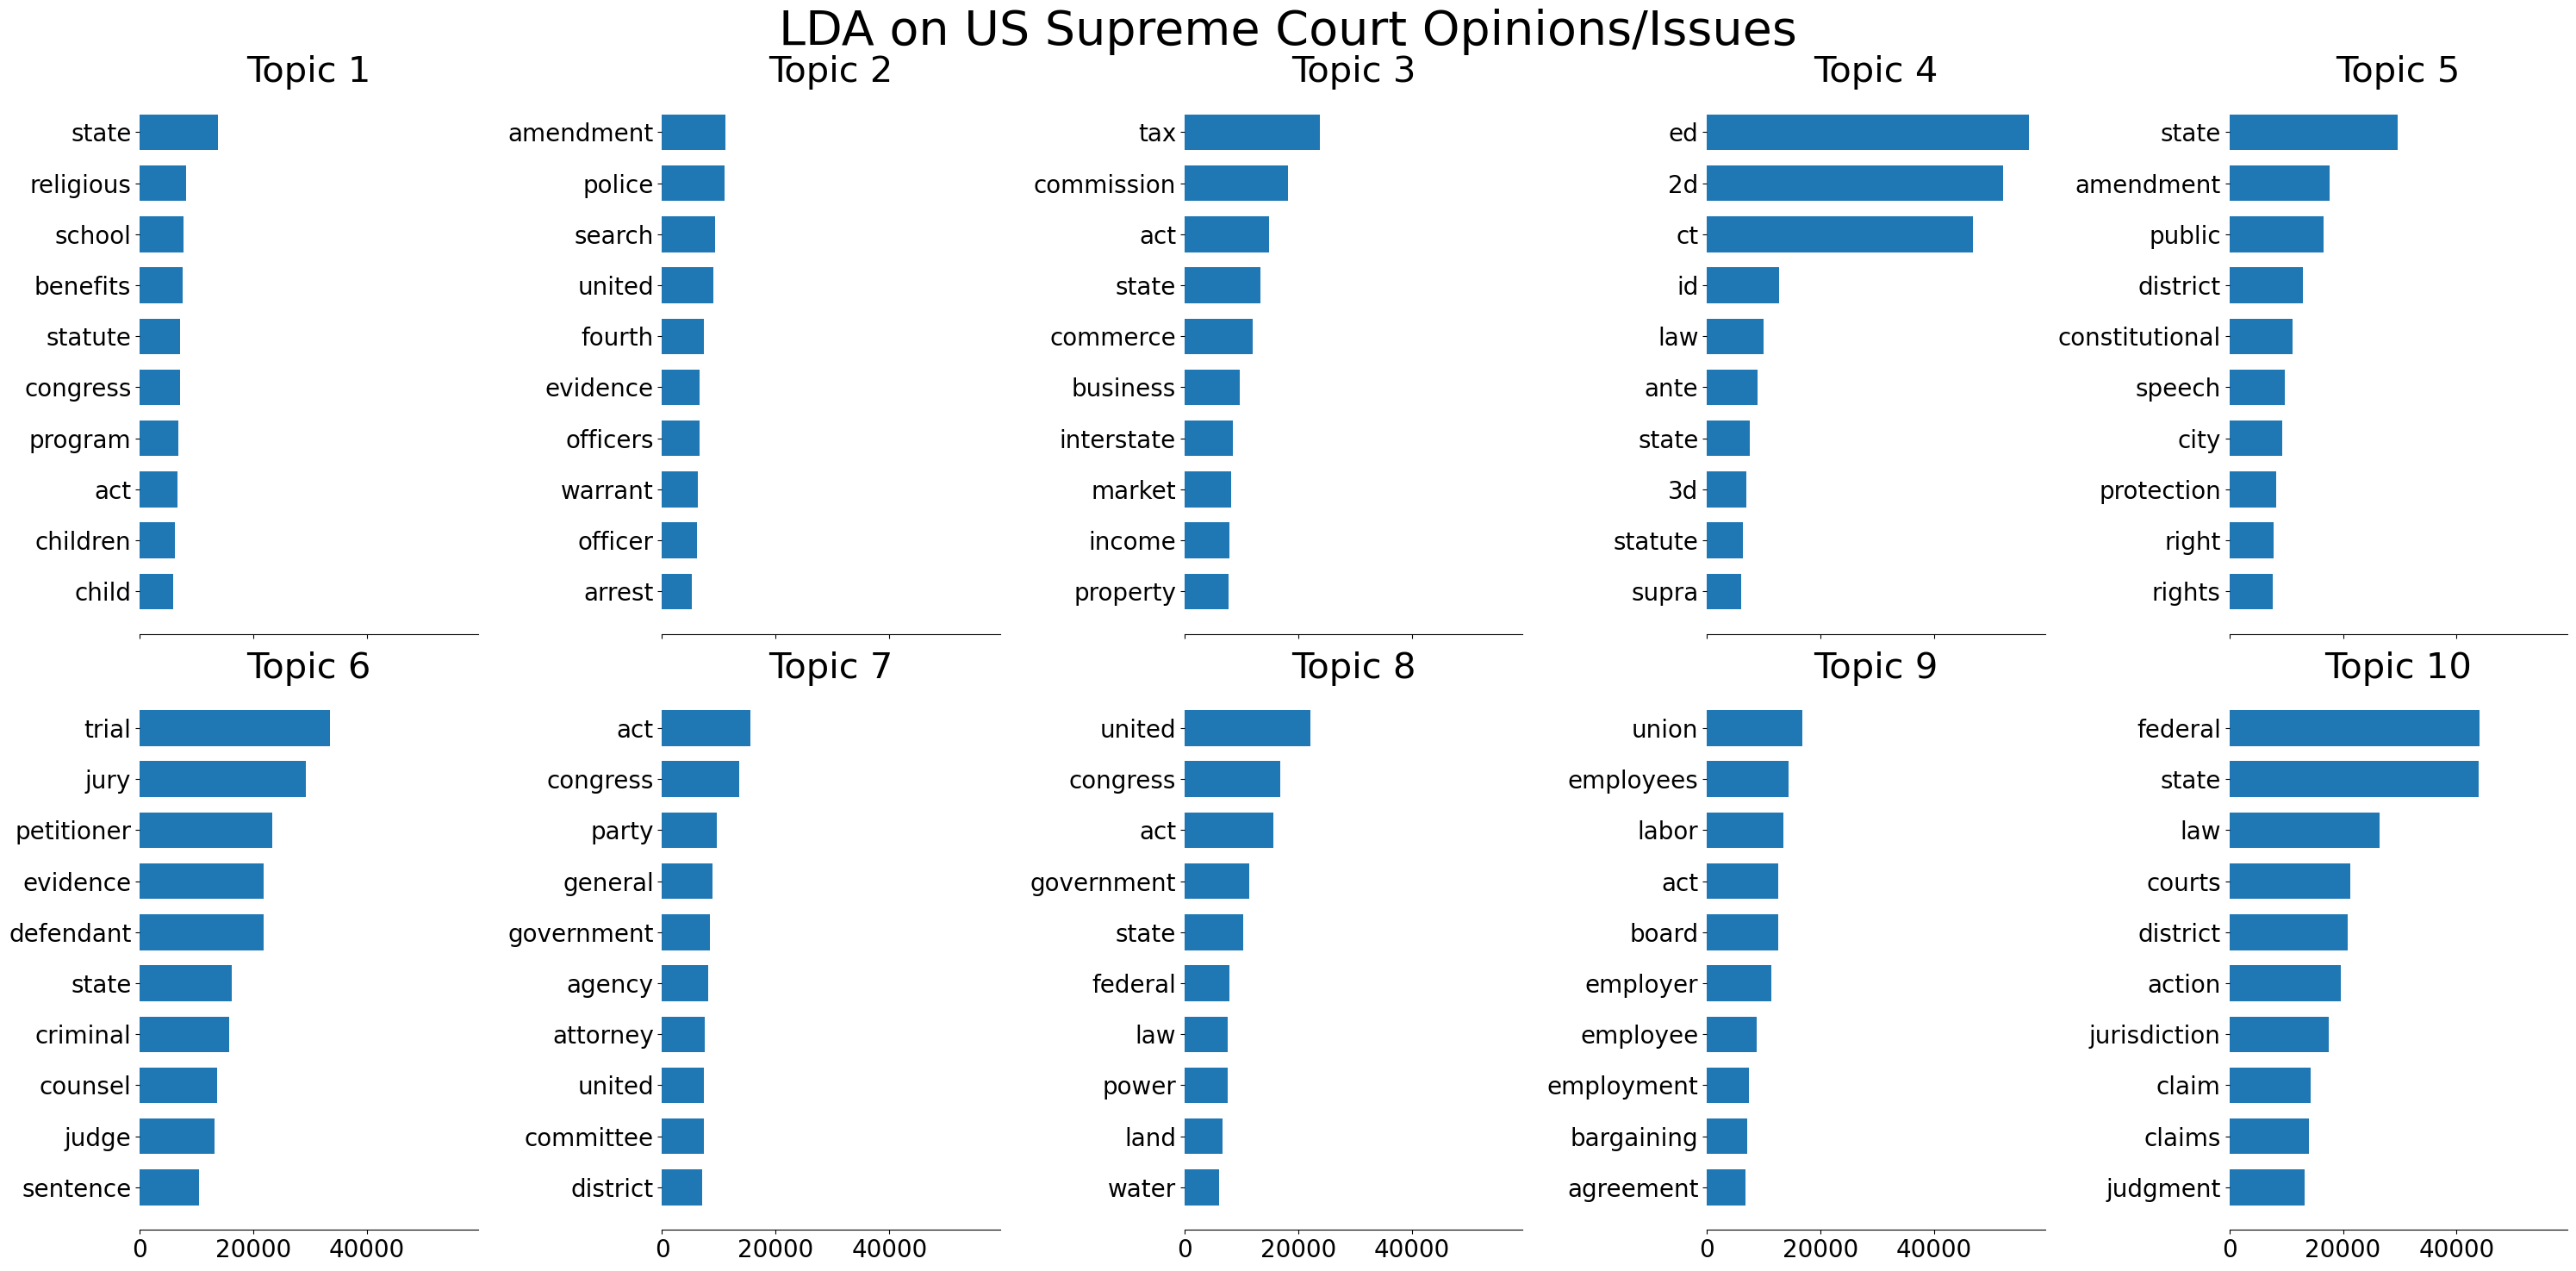

In [13]:
# plot topic output
display_topics(lda, vectorizer.get_feature_names_out(), k_top_words = 10, n_topics = 10, title = "LDA on US Supreme Court Opinions/Issues")

### 9. Compute a doc-topic matrix from your fitted LDA model (5 points)

Compute a doc-topic matrix for the dataset using your fitted LDA model.

`print` the shape of the resulting matrix.

In [14]:
# doc-topic matrix
doc_topic_matrix = lda.transform(vectorized_sc)
print("Doc-topic matrix shape:", doc_topic_matrix.shape)

Doc-topic matrix shape: (13561, 10)


### 10. Predict the issue area of each opinion using topic distributions (10 points)

Use a logistic regression classifier to make multiclass preditions of the `issue_area` of each opinion.

`print` the average cross-validated weighted F1 score for your system. Example:
```
Model performance using topics as features: <num>
```

In [15]:
# classify using topic features
sc_std_topics = StandardScaler().fit_transform(doc_topic_matrix)
encoded_issue_area = LabelEncoder().fit_transform(sc_data['issue_area'])
lr_model = LogisticRegression().fit(sc_std_topics, encoded_issue_area)
issue_area_pred = lr_model.predict(sc_std_topics)

print(f'''Model performance using topics as features: {
  np.mean(cross_val_score(
    LogisticRegression(),
    sc_std_topics, 
    encoded_issue_area, 
    scoring='f1_weighted'))
    }''')

Model performance using topics as features: 0.4920943833522508


### 11. Predict the issue area using the 20 most informative token features (10 points)

Same as the previous problem, but use the 20 most informative token features (as measured by mutual information score) as inputs, rather than topic probabilities.

`print` the shape of your input matrix and  the average cross-validated weighted F1 score for your system.

In [16]:
# classify using informative tokens

twenty_best_sc = SelectKBest(mutual_info_classif, k = 20)
sc_selected_words = twenty_best_sc.fit_transform(vectorized_sc,
                                                  encoded_issue_area)

print(f'Matrix Shape: {sc_selected_words.shape}')


Matrix Shape: (13561, 20)


In [17]:
print(f'''Model performance using 20 most informative token features: {
  np.mean(cross_val_score(
    LogisticRegression(max_iter = 5000),
    sc_selected_words, 
    encoded_issue_area, 
    scoring='f1_weighted'))
    }''')

Model performance using 20 most informative token features: 0.44200230265451557


### 12. Predict the issue area using the top 20 SVD dimensions (10 points)

Same as the previous two problems, but now use the first 20 components of a `TruncatedSVD` representation of the token data as your inputs.

`print` the shape of your input matrix and  the average cross-validated weighted F1 score for your system.

In [18]:
# classify using SVD
svd_twenty = TruncatedSVD(n_components=20)
sc_svd = svd_twenty.fit_transform(vectorized_sc)

print(f'Matrix Shape: {sc_svd.shape}')

print(f'''Model performance using 20 SVD dims: {
  np.mean(cross_val_score(
    LogisticRegression(max_iter = 1000),
    sc_svd, 
    encoded_issue_area, 
    scoring='f1_weighted'))
    }''')

Matrix Shape: (13561, 20)


c:\Users\adika\anaconda3\envs\3350\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\adika\anaconda3\envs\3350\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Model performance using 20 SVD dims: 0.5505997077755506


### 13. Reflect on your results (5 points)

What do you observe when comparing the performance of classifiers using each of the indicated feature inputs? How do you explain the observed differences in performance? Would you expect the same relative performance levels on a different task such as predicting the year of each opinion or its type (controling opinion, concurrence, dissent)?

In my case, none of the three classifiers with different feature inputs performed well -- Truncated SVD and Topic inputs caused the model to have a weighted f1 score of around 0.50 - 0.55, while the mutual information inputs caused the model to have a weighted f1 score of around 0.44.  It does make sense that the two methods involving reducing dimensions (SVD and LDA) performed similarly -- the bad performance may be due to the fact that the reduced features were not as useful for being able to predict issue_area from.  The Mutual Information input performing worse than the other two may suggest (in my case) that the strategy of measuring any relationship in a nonparametric manner is not as effective -- it is most likely not identifying the correct features / feature interactions that issue_area depends on.  Or, it is possible that issue_area simply is not able to properly be represented with the selected features.  On predicting year, I expect that LDA and Truncated SVD would perform better than Mutual Information -- year is a continuous numeric variable, and LDA and SVD might be able to better capture feature importances especially as they change over time.  On predicting type, I expect mutual information to perform better, as less-obvious relationships between certain terms might have greater influence on a case's type.